# Analyse Rotation Spectra - GRF Data

## Load Libraries

In [50]:
from andbro__querrySeismoData import __querrySeismoData
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm_notebook
from pathlib import Path
from scipy.stats import median_absolute_deviation as mad

import os
import pickle
import matplotlib.pyplot as plt

In [51]:
if os.uname().nodename == "lighthouse":
    root_path = "/home/andbro/kilauea-data/"
elif os.uname().nodename == "kilauea":
    root_path = "/import/kilauea-data/"

In [52]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero
    
    min_psd = zeros(psds.shape[1])
    
    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])
    
    return min_psd

In [53]:
def __get_median_psd(psds):

    from numpy import median, zeros, isnan

    med_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        med_psd[f] = median(a[~isnan(a)])

    return med_psd

In [54]:
def __get_minimum_psd(psds, f_tmp):
    
    from numpy import median
    
    f_before = f_tmp[0]
    f_tmp[0] = 1e-9
    
    for i, psd in enumerate(psds):
        if i == 0: 
            lowest_value = (psds[0]/f_tmp).sum()
#             lowest_value = median(psds[0]/f_tmp)
            idx = 0

        value = (psd/f_tmp).sum() 
#         value = median(psd/f_tmp)
        
        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i

    f_tmp[0] = f_before      
    
    return psds[idx]

In [55]:
def __write_to_csv(data, text, config):
    
    import csv
    
    opath = config['outpath']
    oname = config['outname']+"_"+text+"_psd.csv"
    
    # open the file in the write mode
    with open(opath+oname, 'w') as file:

        writer = csv.writer(file)
        for row in data:
            writer.writerow(row)
            
    if Path(opath+oname).exists():
        print(f"created: {opath}{oname}")

In [56]:
def __load_psds(file, config):

    ## get data to dataframe and transpose and reindex
    df = read_csv(file, index_col=False)
    df = df.transpose()
    df.reset_index(inplace=True)
    # df.dtypes
    # df.mean()

    ## set column names
    try:
        columns = pickle.load(open(f"{config['inpath']}{config['inname']}_columns.pick", 'rb'))
        df.columns = [column.replace("-","") for column in columns]
    except:
        columns = arange(0,df.shape[1]).astype(str)
        df.columns = columns
        print(" -> Failed to assign column names! Assigned numbers instead!")

    ## check for column dublicates
    if len(df.columns.unique()) != len(df.columns):
        print(f" -> removing {len(df.columns)-len(df.columns.unique())} column dublicate(s)!")
        df = df.loc[:,~df.columns.duplicated()]

    count=0
    dates_expected = date_range(config['date1'].date, config['date2'].date, periods=int((config['date2']-config['date1'])/86400)+1)
    for dex in dates_expected:
        dex=str(dex.isoformat()[:10]).replace("-","")
        if not dex in df.columns:
            count+=1
    print(f" -> missing {count} days")
        
    print(f" -> total of {df.shape[0]} psds")
        
#     ## convert to list
#     psds = []
#     for col in array(df.columns):
        
#         ## turn non-float series to float objects
#         df[col] = pd.to_numeric(df[col], errors = 'coerce')

#         ## add to psds list
#         psds.append(array(df[col]))
        
    return df

In [57]:
def __get_array_from_dataframe(df):
    
    from pandas import to_numeric
    
    ## convert to list
    psds = []
    for col in array(df.columns):
        
        ## turn non-float series to float objects
        df[col] = to_numeric(df[col], errors = 'coerce')

        ## add to psds list
        psds.append(array(df[col]))

    return array(psds)

In [58]:
def __remove_noisy_psds(df, threshold_mean=1e-13):

    from numpy import delete
    
    l1 = len(df.columns)
    for col in df.columns:
#         print(col, type(col))
        if df[col].astype(float).mean() > threshold_mean:
            df = df.drop(columns=col)
    l2 = len(df.columns)
    print(f" -> removed {l1-l2} columns due to mean thresholds!")
    print(f" -> {l2} psds remain")
    
    return df

In [59]:
# !ls "/import/kilauea-data/ROMY/RotationSpectra/data"
!ls "/home/andbro/kilauea-data/ROMY/RotationSpectra/data"

overview		     run_2019_RGRF-Z_3600_run7
run_2019_FUR-Z_3600	     run_2019_RGRF-Z_3600_run8
run_2019_FUR-Z_3600_testday  run_2019_RGRF-Z_3600_run9
run_2019_RGRF-_3600_GRA2     run_2019_RLAS-Z_3600
run_2019_RGRF-E_3600_GRA     run_2019_RLAS-Z_3600_hours
run_2019_RGRF-E_3600_GRA1    run_2019_RLAS-Z_3600_testday
run_2019_RGRF-E_3600_GRA2    run_2019_ROMY_ADR-E_3600
run_2019_RGRF-E_3600_GRB     run_2019_ROMY_ADR-E_3600_all
run_2019_RGRF-E_3600_GRB1    run_2019_ROMY_ADR-N_3600_all
run_2019_RGRF-E_3600_GRB2    run_2019_ROMY_ADR-Z_3600
run_2019_RGRF-E_3600_GRC     run_2019_ROMY_ADR-Z_3600_all
run_2019_RGRF-E_3600_GRC1    run_2019_ROMY_ADR-Z_3600_classic
run_2019_RGRF-E_3600_GRC2    run_2019_ROMY-E_3600
run_2019_RGRF-E_3600_GRF     run_2019_ROMY-U_3600_hours
run_2019_RGRF-E_3600_GRF1    run_2019_ROMY-V_3600_hours
run_2019_RGRF-E_3600_GRF2    run_2019_ROMY-W_3600_hours
run_2019_RGRF-E_3600_GRF3    run_2019_ROMY-Z_3600
run_2019_RGRF-N_3600_GRA     run_2019_ROMY-Z_3600_2hours
run_2019_RGRF-N_3600

## Configurations

In [102]:
# inname = "run_2019_RGRF-Z_3600_test_sensitivity"
# inname = "run_2019_RGRF-Z_3600_test"
inname = "run_2019_RGRF-E_3600_GRF"

inpath = f"{root_path}/ROMY/RotationSpectra/data/{inname}/"

# config = pickle.load(open(inpath+inname+"_config.pick", 'rb'))
config = pickle.load(open(inpath+inname+"_config.pkl", 'rb'))

config['save'] = True

config['inname'] = inname
config['inpath'] = inpath

config['frequency_limits'] = [1/200, 1]

## Processing 

In [103]:
## load set of minimum psds
file = f"{config['inpath']}{config['inname']}_daily_medians.pkl"

print(f" -> loading {file} ...")
psds_all = read_pickle(file)

if not psds_all.empty:
    print(psds_all.head())
else: 
    print(" -> failed to load!")
    
## load frequencies
ff = pickle.load(open(f"{config['inpath']}{config['inname']}_frequency_axis.pkl", 'rb'))

 -> loading /home/andbro/kilauea-data//ROMY/RotationSpectra/data/run_2019_RGRF-E_3600_GRF/run_2019_RGRF-E_3600_GRF_daily_medians.pkl ...
       20190101      20190102      20190103      20190104      20190105  \
0  1.608143e-23  1.465282e-23  1.667355e-23  2.155084e-23  1.227292e-23   
1  1.355414e-22  1.084240e-22  1.083515e-22  9.759657e-23  1.259140e-22   
2  1.201696e-22  1.235013e-22  9.874062e-23  1.375417e-22  1.258447e-22   
3  2.459756e-23  4.036085e-23  3.126194e-23  3.125284e-23  2.982911e-23   
4  7.744058e-24  1.238493e-23  8.052594e-24  6.834562e-24  9.259607e-24   

       20190106      20190107      20190108      20190109      20190110  ...  \
0  8.322784e-24  6.590600e-24  1.253420e-23  1.113537e-23  6.253531e-24  ...   
1  6.395646e-23  7.180749e-23  8.820802e-23  6.349582e-23  7.030913e-23  ...   
2  6.112770e-23  8.511401e-23  9.700291e-23  8.959294e-23  8.526210e-23  ...   
3  1.171688e-23  1.924645e-23  2.637796e-23  2.892646e-23  2.317666e-23  ...   
4  5.626582e

In [104]:
psds = __get_array_from_dataframe(psds_all)

columns = psds_all.columns

Cut to frequency axis and matrices to frequency limits as specified in config

In [105]:
ind = []
for i,f in enumerate(ff):
    if f >= config['frequency_limits'][0] and f <= config['frequency_limits'][1]:
        ind.append(i)

ff = ff[ind[0]:ind[-1]]
psds = psds[:,ind[0]:ind[-1]]

Compute median, minium and minimal PSD and store it as DataFrame

In [106]:
psds_minimal = __get_minimal_psd(array(psds))
# psds_minimum = __get_minimum_psd(array(psds), ff)
psds_median = __get_median_psd(array(psds))

In [107]:
out_df = DataFrame()

out_df['frequencies'] = ff
out_df['minimal'] = psds_minimal
out_df['median'] = psds_median

print(f" -> write statistics to: {config['inpath']}{config['inname']}_stats.pkl")
out_df.to_pickle(f"{config['inpath']}{config['inname']}_stats.pkl")

 -> write statistics to: /home/andbro/kilauea-data//ROMY/RotationSpectra/data/run_2019_RGRF-E_3600_GRF/run_2019_RGRF-E_3600_GRF_stats.pkl


## Plotting

In [108]:
def __makeplot_colorlines(config, ff, psds, columns):

    from numpy import isnan, median, mean, std, array
    from scipy.stats import median_abs_deviation as mad
    
    psds_median, psds_mean, psds_std, psds_mad = [],[],[],[]
    for fcross in range(psds.shape[1]):
        data = psds[:,fcross]
        psds_median.append(median(data[~isnan(data)]))
        psds_mean.append(mean(data[~isnan(data)]))
        psds_std.append(std(data[~isnan(data)]))
        psds_mad.append(mad(data[~isnan(data)]))
        
    psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)
    
        
    ##____________________________
    
    fig, ax = plt.subplots(1,1, figsize=(15,10), sharey=False, sharex=True)

    font = 12

    N = psds.shape[0]
    colors = plt.cm.rainbow(linspace(0, 1, N))

    for n, psd in enumerate(psds):
        ax.loglog(ff, psd, color=colors[n], alpha=0.7)


    ## add scatter for colorbar object only
    for n, psd in enumerate(psds):
        p2 = ax.scatter(ff[0], psd[0], s=0., c=n, cmap='rainbow', vmin=0, vmax=N)


    ax.loglog(ff, psds_median, 'black', zorder=3, alpha=0.9)
#     ax.loglog(ff, psds_mean, 'black', zorder=3, alpha=0.9)
#     ax.loglog(ff, psds_minimal, 'black', zorder=2, alpha=1.0)
#     ax.loglog(ff, psds_minimum, 'k', zorder=2, alpha=0.8)
    

    ## theoretical rlnm
    rlnm = read_csv(f"{root_path}/LNM/data/MODELS/rlnm_theory.csv")
    ax.loglog(rlnm['period'], rlnm['rlnm_psd_median'], color="grey", zorder=2, lw=2, label="RLNM")

    
    ax.set_xlabel("Period (s)", fontsize=font)

    ax.set_ylabel(r"PSD (rad$^2$/s$^2$/$Hz)$", fontsize=font)
    
    ax.grid(True, which="both", ls="-", alpha=0.5)
    
    ax.set_xlim(min(ff), max(ff))
    ax.set_ylim(1e-26,1e-19)
#     ax.set_xlim(10**log10(config['frequency_limits'][0]), 10**log10(config['frequency_limits'][1]))
    
    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='horizontal', ax=ax, aspect=50)

    ## redefine ticks of colorbar
    dates = columns
    new_ticks=[]
    for t in cbar.get_ticks(): 
        new_ticks.append(dates.astype(str)[int(t)])
    cbar.ax.set_xticklabels(new_ticks)


    plt.show();
    
    out = DataFrame()
    out['frequencies'] = ff
    out['psds_minimal'] = array(psds_minimal)
    out['psds_median'] = array(psds_median)
    out['psds_mean'] = array(psds_mean)
    out['psds_std'] = array(psds_std)
    out['psds_mad'] = array(psds_mad)
    
    
    return fig, out

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator


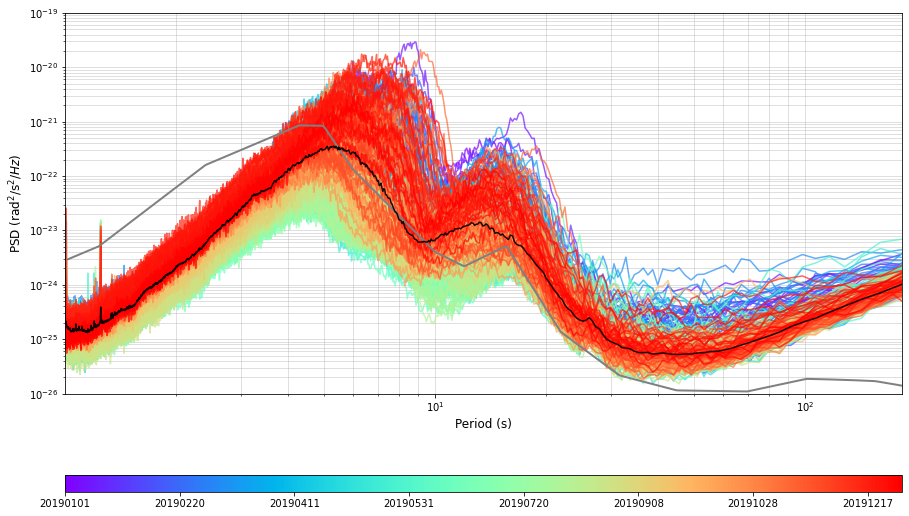

In [109]:
fig, out = __makeplot_colorlines(config, 1/ff, psds, columns)

### Write to File

In [ ]:
# if config['save']:
#     out.to_csv(f"{inpath}{inname}.csv", sep=",")
#     print(f" -> writing to {inpath}{inname}.csv")

## Plot as DeciBel

In [ ]:
def __conversion(data, informat=None, outformat=None):
    '''
    data:                  array 
    informat/outformat:    ASD, PSD, DB
    '''
    from numpy import log10, sqrt
    
    
    if informat == 'ASD' and outformat == 'PSD':
        return data**2
    
    elif informat == 'PSD' and outformat == 'ASD':
        return sqrt(data)

    elif informat == 'ASD' and outformat == 'DB':
        return 10*log10(data)
    
    elif informat == 'PSD' and outformat == 'DB':
        return 10*log10(data)
    
    elif informat == 'DB' and outformat == 'PSD':
        return 10**(data/10)
    
    elif informat == 'DB' and outformat == 'ASD':
        return sqrt(10**(data/10))
    
    else:
        print(" -> specified case not defined!")

In [ ]:
psds_db = __conversion(psds, informat="PSD", outformat="DB")

In [ ]:
def __makeplot_colorlines_decibel(config, ff, psds, columns):

    from numpy import isnan, median, mean, std, array
    from scipy.stats import median_abs_deviation as mad
    
    psds_median, psds_mean, psds_std, psds_mad = [],[],[],[]
    for fcross in range(psds.shape[1]):
        data = psds[:,fcross]
        psds_median.append(median(data[~isnan(data)]))
        psds_mean.append(mean(data[~isnan(data)]))
        psds_std.append(std(data[~isnan(data)]))
        psds_mad.append(mad(data[~isnan(data)]))
    
    psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)
    
    
    ##____________________________
    
    fig, ax = plt.subplots(1,1, figsize=(15,10), sharey=False, sharex=True)

    font = 12

    N = psds.shape[0]
    colors = plt.cm.rainbow(linspace(0, 1, N))


    for n, psd in enumerate(psds):
        ax.semilogx(ff, psd, color=colors[n], alpha=0.7)

    ## add scatter for colorbar object only
    for n, psd in enumerate(psds):
        p2 = ax.scatter(ff[0], psd[0], s=0., c=n, cmap='rainbow', vmin=0, vmax=N)

    ax.semilogx(ff, psds_median, 'black', zorder=3, alpha=0.9)
    ax.semilogx(ff, array(psds_median)+array(psds_mad), 'grey', zorder=3, alpha=0.8)  
    ax.semilogx(ff, array(psds_median)-array(psds_mad), 'grey', zorder=3, alpha=0.8)  

#     ax.semilogx(ff, psds_minimal, 'black', zorder=2, alpha=1.0)
    

    ax.set_xlabel("Frequency (Hz)", fontsize=font)

    ax.set_ylabel(r"PSD (dB rel. to 1 $rad^2$/($s^2$ $Hz$)", fontsize=font)
  
    ax.grid(True, which="both", ls="-", alpha=0.5)

    
    ax.set_xlim(min(ff), max(ff))
#     ax.set_xlim(10**log10(config['frequency_limits'][0]), 10**log10(config['frequency_limits'][1]))
    
    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='horizontal', ax=ax, aspect=50)

    ## redefine ticks of colorbar
    dates = columns
    new_ticks=[]
    for t in cbar.get_ticks(): 
        new_ticks.append(dates.astype(str)[int(t)])
    cbar.ax.set_xticklabels(new_ticks)


    plt.show();
    
    out = DataFrame()
    out['frequencies'] = ff
    out['psds_minimal'] = array(psds_minimal)
    out['psds_median'] = array(psds_median)
    out['psds_mean'] = array(psds_mean)
    out['psds_std'] = array(psds_std)
    out['psds_mad'] = array(psds_mad)
    
    return fig, out

In [ ]:
fig, out_db = __makeplot_colorlines_decibel(config, ff, psds_db, columns)

### Write to file

In [ ]:
# if config['save']:
#     out_db.to_csv(f"{inpath}{inname}_DB.csv", sep=",")
#     print(f" -> writing to {inpath}{inname}_DB.csv")

## Calculate and Plot Density

In [ ]:
output = __calculate_density(psds, bins=100, density=True)

In [ ]:
def __makeplot_PPSD(ff, output, config, mode=None):

    from matplotlib import colors
    from numpy import ones, convolve, array, log10, roll, sqrt

    bins, bins_medians, bins_maximas, dist = output['bin_mids'], output['bins_medians'], output['bins_maximas'], output['dist']
    
    if mode is "DB":
        y_axis = 10*log10(bins)
    elif mode is "PSD":
        y_axis = bins
    elif mode is "ASD":
        y_axis = sqrt(bins)
        
    x_axis = ff

    ## plotting
    fig, ax = plt.subplots(1,1,figsize=(13,6))

    font=14

    cmap = plt.cm.get_cmap('magma_r')
#     cmap = plt.cm.get_cmap('gray_r')
    cmap.set_under(color='white')

    im = plt.pcolor(x_axis, y_axis, dist.T, 
                    cmap=cmap,
                    vmin=1e-12, 
                    alpha=0.99,
                   )

    ## add Frequency Axis
    g = lambda x: 1/x
    ax2 = ax.secondary_xaxis("top", functions=(g,g))
    ax2.set_xlabel("Frequency in Hz", fontsize=font, labelpad=5)
    ax2.set_xticklabels(1/ff, fontsize=11)    
    
    
    if mode is "DB":
        plt.plot(x_axis, 10*log10(bins_medians), color='black', alpha=0.5, label="RNLM")
        plt.ylim(-200, -80)

    elif mode is "PSD":
        plt.plot(x_axis, bins_medians, color='black', alpha=0.5, label="RNLM")
        plt.yscale('log')
        plt.ylim(10**-20, 10**-13)
  
    elif mode is "ASD":  
        plt.plot(x_axis, sqrt(bins_medians), color='black', alpha=0.5, label="RNLM")
        plt.yscale('log')
        plt.ylim(10**-10, 2*10**-7)

    
#     plt.fill_betweenx(range(-270, -140), x1=0, x2=2.5, color="grey", alpha=0.4)
#     plt.fill_betweenx(range(-270, -140), x1=200, x2=max(ff), color="grey", alpha=0.4)

    ## modify x-axis
    plt.xscale('log')
    plt.xlim([min(x_axis), max(x_axis)])
#     plt.xlim(1, 300)
    
    ## add colorbar
    caxes = fig.add_axes()
    cb = plt.colorbar(im, cax=caxes, alpha=1.0)
    
    if output['set_density']:
        cb.set_label("Propability Density", fontsize=font)
    else:
        cb.set_label("Counts", fontsize=font)
        cb.set_label("Propability Density", fontsize=font)
    
    if mode is "DB":
#         plt.ylabel(r"PPSD in dB (rel. to 1 m$^4$/s$^2$/$Hz$)", fontsize=font)
        plt.ylabel(r"PPSD in dB (rel. to 1 rad$^2$/s$^2$/$Hz$)", fontsize=font)
    elif mode is "PSD":
#         plt.ylabel(r"PPSD in m$^4$/s$^2$/$Hz$", fontsize=font)
        plt.ylabel(r"PPSD in $\frac{rad^2}{s^2 Hz}$", fontsize=font)
    elif mode is "ASD":
        plt.ylabel(r"PASD in $\frac{rad}{s \sqrt{Hz}}$", fontsize=font)
        
    plt.grid(axis="both", which="both", ls="--", zorder=0)
    plt.legend()
    
    plt.xlabel("Period in seconds", fontsize=font)

    plt.tick_params(axis='both', labelsize=font-2)

    plt.show();
    return fig

In [ ]:
fig = __makeplot_PPSD(ff, output, config, mode="ASD")